In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os
import math

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('legend', title_fontsize=10)
plt.rc('figure', titlesize=10)

plt.rc('legend', framealpha=0.0)
plt.rc('lines', linewidth=1.5)

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'
plt.rcParams['font.family'] = "Times New Roman"
# plt.rcParams['font.serif'] = ['Computer Modern']

matplotlib.rcParams['figure.figsize'] = (textwidth := 5.5, 2.0)
matplotlib.rcParams['figure.dpi'] = 150

colorize = lambda dim_list, colormap : [colormap(i) for i in np.linspace(0.0, 0.92, len(dim_list))]

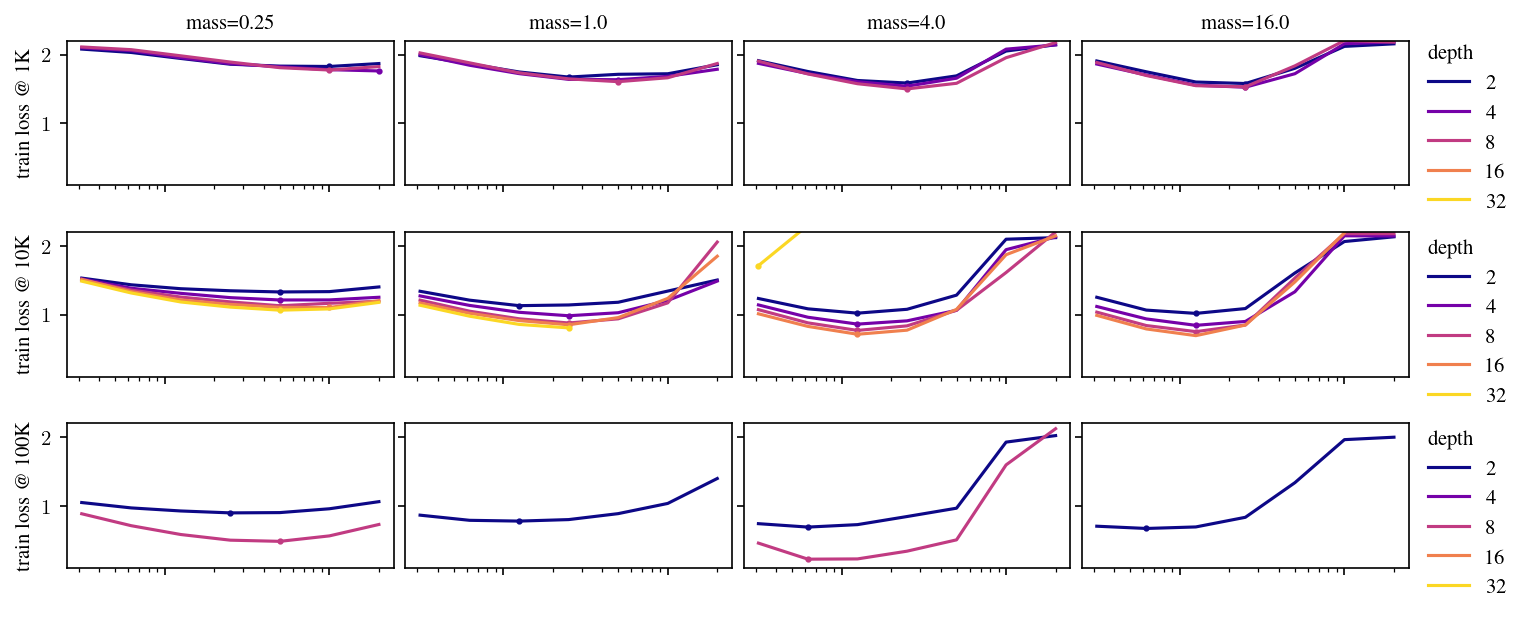

In [177]:
def get_run(dataset='cifar10', arch='vit', 
            beta1=0.9, beta2=0.99, wd=0.0, sch='cosine',
            train_steps=1000, batch_size=128,
            num_head=4, patch_size=4, context=256,
            width=64, depth=4, 
            initial_depth=1, block_depth=1, final_depth=1,
            initial_mass=1.0, body_mass=1.0, final_mass=1.0,
            key='train_loss', 
            verbose=0):
    
    if arch == 'vit':
        part1 = "{}_{}_{}_{}".format(beta1,beta2,wd,sch)
        part2 = "{}_{}".format(train_steps,batch_size)
        part3 = "{}".format(arch)
        part4 = "{}_{}_{}_{}_{}_{}_{}".format(patch_size, num_head, width, depth, initial_mass, body_mass, final_mass)
    
    logdir = os.path.join("..", "logs", part1, part2, part3, part4)
    #print(logdir)
    optim = 'sgd'
    normalize = 0
    if optim == "adam" and normalize != "normalize":
#         lr_list = [0.00012207031, 0.00024414062, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]        
        lr_list = [0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]
#     elif dataset == "shakespeare" and normalize == "normalize":
#         lr_list = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
    else:
        lr_list = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0]
    
    returned_result_list = []
    returned_lr_list = []
    
    for lr in lr_list:
        try:
            with open(os.path.join(logdir, str(lr), 'results.pickle'), "rb") as file:
                r = pickle.load(file)
                #print(r.keys())
                results = r[key]
            if 'train' in key:
                average_result = np.mean(results[-50:])
            else:
                if 'loss' in key:
                    average_result = np.mean(results[-2:])
                else:
                    average_result = np.mean(results[-1:])
            returned_result_list.append(average_result)
            returned_lr_list.append(lr)
        except:
            if verbose:
                print(f"warning: missing {optim} {normalize} width={width} depth={depth} lr={lr}")
                
        try:
            with open(os.path.join(logdir, str(lr), 'args.pickle'), "rb") as file:
                args = pickle.load(file)
        except:
            args = {}
    
    return returned_lr_list, returned_result_list, args

width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128
depth_list = [2, 4, 8, 16, 32]; this_width = 128
mass_list  = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]
mass_list  = [0.25, 1.0, 4.0, 16.0]
step_list  = [1000, 10000, 100000]
#step_list  = [1000, 10000]
beta1 = 0.9
beta2 = 0.99
wd = 0.0
sch = 'cosine'

matplotlib.rcParams['figure.figsize'] = (textwidth := 10, 10)
matplotlib.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(len(step_list), len(mass_list), sharey=True)
fig.set_figheight(4)

axis = 0
key='train_loss'#'train_loss'#'test_loss'
for s, step in enumerate(step_list):
    for i, mass in enumerate(mass_list):
        colors = colorize(depth_list, plt.cm.plasma)
        
        for d, depth in enumerate(depth_list):
            lr_list, result_list, args = get_run(depth=depth,body_mass=mass,train_steps=step,key=key)
            
            axes[s,i].plot(lr_list, result_list, color=colors[d], label=depth)
            if result_list:
                if 'acc' in key:
                    best_lr = np.argmax(result_list)
                else:
                    best_lr = np.argmin(result_list)
                axes[s,i].plot(lr_list[best_lr], result_list[best_lr], 'o', color=colors[d], markersize=2)
            
        axes[s,i].set_xscale("log")
        axes[s,i].set_xticklabels([])
        title = "betas_{}_{}_wd_{}_{}".format(beta1,beta2,wd,sch)
        title = "mass={}".format(mass)
        if s == 0:
            axes[s,i].set_title(title)
    axes[s,0].set_ylabel("{} @ {}K".format(" ".join(key.split('_')),step//1000))

axes[0,len(mass_list)-1].legend(title="depth", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
axes[1,len(mass_list)-1].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"
axes[2,len(mass_list)-1].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"

#axes[0,0].set_yscale("log")
axes[0,0].set_ylim(1.22,2.25)
axes[1,0].set_ylim(0.8,2.25)
axes[2,0].set_ylim(0.1,2.2)

#axes[2,0].set_ylim(0.3,0.9)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("sweep-vit-cifar-mass.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


# ResMLP sweeps

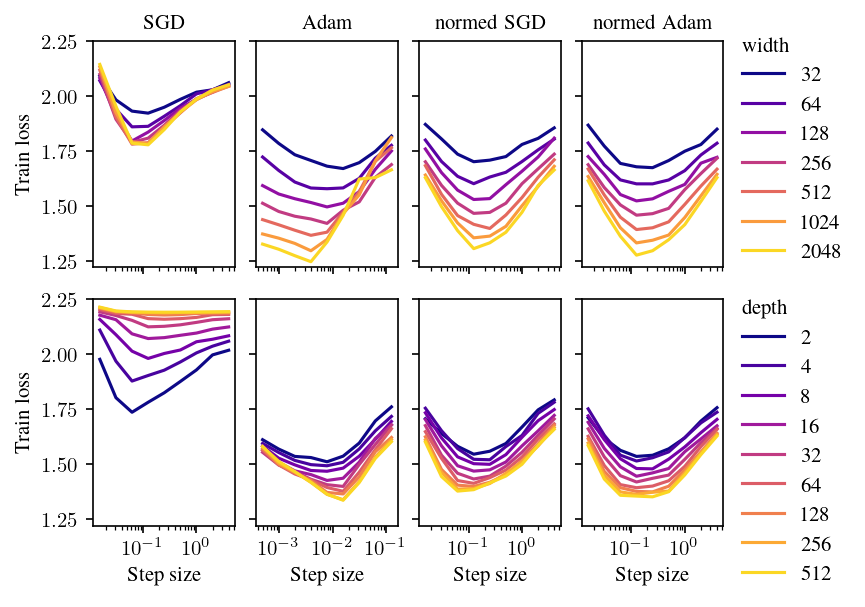

In [4]:
width_list = [32, 64, 128, 256, 512, 1024, 2048]; this_depth = 3
depth_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]; this_width = 128

dataset = "cifar10"
arch = "resmlp"
key = "train_loss"

fig, axes = plt.subplots(2, 4, sharey=True)
fig.set_figheight(4)

axis = 0
lr_list, result_list, args = get_run(dataset, arch, optim, normalize, width, this_depth, key)

for normalize in "unnormalize", "normalize":
    for optim in "sgd", "adam":
        for width, color in zip(width_list, colorize(width_list, plt.cm.plasma)):
            
            axes[0,axis].plot(lr_list, result_list, color=color, label=width)
            axes[0,axis].set_xscale("log")
            axes[0,axis].set_xticklabels([])
            title = "SGD" if optim == "sgd" else "Adam"
            if normalize == "normalize": title = "normed " + title
            axes[0,axis].set_title(title)
        for depth, color in zip(depth_list, colorize(depth_list, plt.cm.plasma)):
            lr_list, result_list, args = get_run(dataset, arch, optim, normalize, this_width, depth, key)
            axes[1,axis].plot(lr_list, result_list, color=color, label=depth)
            axes[1,axis].set_xscale("log")
            axes[1,axis].set_xlabel("Step size")
        axis += 1
axes[0,0].set_ylabel("Train loss")
axes[1,0].set_ylabel("Train loss")

axes[0,3].legend(title="width", bbox_to_anchor=(1.0, 1.10))._legend_box.align = "left"
axes[1,3].legend(title="depth", bbox_to_anchor=(1.0, 1.08))._legend_box.align = "left"

axes[0,0].set_ylim(1.22,2.25)

plt.tight_layout(pad=0, w_pad=0.2)
plt.savefig("sweep-resmlp.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Architecture sweeps